# python launcher

In [46]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    scenario = 'ambicioso_sitp_30'
    manual = True

In [47]:
scenario

'ambicioso_sitp_30'

In [48]:
import geopandas as gpd
import pandas as pd

work_path = r'../../../'
quetzal_path = r'../../'

import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel

# jupyter launcher

In [49]:
if manual:
    %matplotlib inline

networkcasted = stepmodel.read_zip(quetzal_path + r'model/preparation/networkcasted.zip')
zonemodel = stepmodel.read_zip(quetzal_path + r'model/preparation/walkmodel.zip')
sm = networkcasted.copy()
sm.zones = zonemodel.zones.copy()

zones: 100%|██████████| 27/27 [00:10<00:00,  2.68it/s]          


# scenario links

In [50]:
read_links =  stepmodel.read_zip(quetzal_path +'model/' + scenario + '/links.zip')

read_links.integrity_test_circular_lines()
read_links.integrity_fix_sequences()

sm.links = read_links.links.copy()

links: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


dropped broken sequences: ['MB_M66D_2', 'MB_M66D_1', 'MB_M66C_1']


In [51]:
l = sm.links

In [52]:
set(l.loc[l['route_type'] == 'subway']['route_id'])

{'m1', 'm2_completo'}

# parameters

In [53]:
parameter_frame = pd.read_excel(quetzal_path + r'inputs/parametros.xlsx').set_index(['category','parameter'])
for c in parameter_frame.columns:
    parent = parameter_frame[c][('general', 'parent')]
    try:
        parent = parent.iloc[0]
    except AttributeError:# 'str' object has no attribute 'iloc'
        pass
    parameter_frame[c] = parameter_frame[c].fillna(parameter_frame[parent])
var = parameter_frame[scenario]

# links

In [54]:
links = sm.links
links['length'] = links['geometry'].apply(lambda g: g.length)
#links['road_link_list'] = links['road_link']

In [55]:
links['time'] = links['length'] / 1000 * 3600 / links['speed']

# walkmodel

In [56]:
short_leg_speed = float(var['general']['short_leg_speed'])
long_leg_speed = float(var['general']['long_leg_speed'])
threshold= float(var['general']['ntleg_threshold'])
footpath_speed= float(var['general']['footpath_speed'])
max_footpath_length = float(var['general']['max_footpath_length'])
max_ntleg_length = float(var['general']['max_ntleg_length'])

In [57]:
short_leg_speed, long_leg_speed, threshold, max_footpath_length, max_ntleg_length

(4.4, 12.0, 300.0, 1000.0, 2000.0)

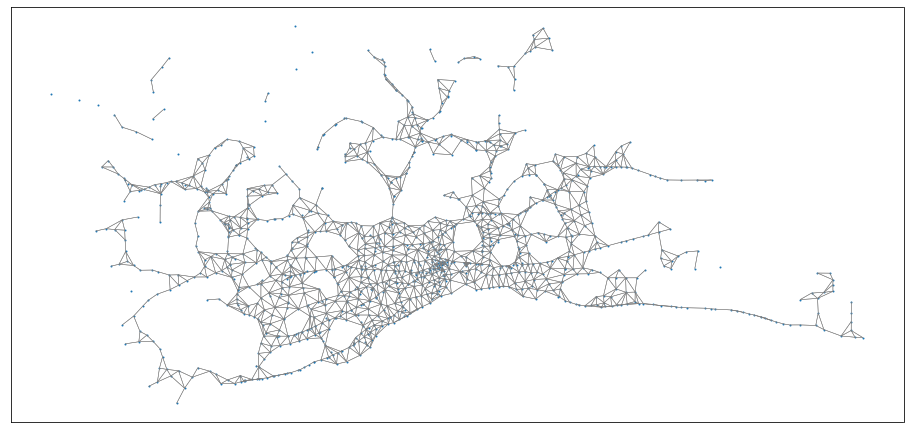

In [58]:
sm.preparation_footpaths(max_length=max_footpath_length, n_clusters=1000)

if manual:
    plot = sm.plot(
        'footpaths', color='grey', linewidth=0.5,
        ax=sm.plot('nodes', markersize=1, figsize=[16, 9] )
    )

In [59]:
sm.preparation_ntlegs(
    n_ntlegs=10,
    max_ntleg_length=max_ntleg_length,
    short_leg_speed=short_leg_speed,
    long_leg_speed=long_leg_speed,
    threshold=threshold,
    zone_to_transit=True,
    zone_to_road=False
)
sm.zones = sm.zones.loc[
    [i for i in sm.zones.index if i in set(sm.zone_to_transit['a'])]
]

In [60]:
sm.road_links['length'] = sm.road_links['geometry'].apply(lambda g: g.length)

# pathfinder

In [61]:
no_concho = sm.copy()
no_concho.links = no_concho.links.loc[~no_concho.links['route_type'].isin(['concho', 'minibus'])]

In [62]:
no_concho.analysis_lines()

In [63]:
sm.links['route_type_group'] = sm.links['route_type']

sm.links.loc[
    sm.links['route_type_group'].isin(['tram', 'subway', 'gondola']), 
    'route_type_group'
] = 'guided'
sm.links.loc[
    sm.links['route_type_group'].isin(['bus', 'express_bus']), 
    'route_type_group'
] = 'bus'
sm.links.loc[
    sm.links['route_type_group'].isin(['bus', 'guided']), 
    'route_type_group'
] = 'heavy'

In [64]:
set(sm.links['route_type_group'])

{'concho', 'heavy', 'minibus'}

In [65]:
len(no_concho.links), len(sm.links)

(1187, 10621)

In [66]:
sm.analysis_lines()

In [67]:
sm.lines['route_type_group'].value_counts()

concho     234
minibus    163
heavy       70
Name: route_type_group, dtype: int64

In [68]:
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    mode_column='route_type_group'
)

breaking modes: {'concho', 'heavy', 'minibus'} :   0%|          | 0/8 [00:00<?, ?it/s]

Pathfinder failed with prune=True. Trying with prune=False


breaking modes: {'concho', 'minibus'} :  25%|██▌       | 2/8 [00:00<00:02,  2.67it/s]         

Pathfinder failed with prune=True. Trying with prune=False


path_analysis: 100%|██████████| 82621/82621 [00:02<00:00, 38428.41it/s]


In [69]:
no_concho.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False, 
    speedup=True
)
sm.pt_los = pd.concat([sm.pt_los, no_concho.pt_los]).drop_duplicates(subset=['path'])

path_analysis: 100%|██████████| 56668/56668 [00:01<00:00, 41758.75it/s]


In [70]:
sm.pt_los['pathfinder_session'].value_counts()

mode_breaker     82621
route_breaker    40551
Name: pathfinder_session, dtype: int64

In [71]:
sm.to_zip(quetzal_path + 'model/%s/pt_pathfinder.zip' % scenario, omitted_attributes=['road_links', 'road_nodes'])

pt_los: 100%|██████████| 26/26 [00:01<00:00, 17.03it/s]                   
